In [1]:
from zipfile import ZipFile
file_name = "data_flowers.zip"

with ZipFile(file_name, "r") as zip:
  zip.extractall()
  print("Done")

Done


In [0]:
%matplotlib inline

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os

from skimage.io import imread
from skimage.transform import resize

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam


# Classification of flowers

## Author: Mehmed Cholakov

### Abstract:
The aim of the study is to train a neural network to predict 5 types of flowers (daisy, dandelion, rose, sunflower, tulip). A convolutional neural network is trained.


### Data Analysis
The data contains 4242 images of 5 types of flowers in separate folders:
 - daisy
 - Dandelion
 - rose
 - sunflower
 - Tulip

After reading the images ("image_data"), I also separate the categories ("image_labels").

In [3]:
folders = os.listdir("data_flowers/flowers/")
image_data = []
image_label = []
valid_extensions_list = ['jpg','tif','png','bmp']
for dir_class in folders:
    for file in os.listdir("data_flowers/flowers/" + dir_class):
        ext = file.split('.')[-1]
        if ext in valid_extensions_list:
            data = imread("data_flowers/flowers/" + dir_class + '/' + file)
            resized_data = resize(data, (100,100))
            image_data.append(resized_data)
            image_label.append(dir_class)
        else:
            pass

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [0]:
image_data = np.array(image_data, dtype = "float32")

### Data preparation




#### 1. We share the data


Normalize RGB values ​​between 0 and 1. Then the flowers I'm going to predict convert to numeric labels. Finally, I stir the data.

In [0]:
image_data = image_data / 255.0

In [6]:
image_label = pd.Series(image_label)
image_label.value_counts()

dandelion    1052
tulip         984
rose          784
daisy         769
sunflower     734
dtype: int64

In [7]:
label_dumies = pd.get_dummies(image_label)
labels =  label_dumies.values.argmax(1)
pd.value_counts(labels)

1    1052
4     984
2     784
0     769
3     734
dtype: int64

In [0]:
union_list = list(zip(image_data, labels))
np.random.shuffle(union_list)
image_data, labels = zip(*union_list)

In [0]:
image_data = np.array(image_data)
labels = np.array(labels)


#### 2. Separate training and validation data.

Once I divide the data I show the ratio of the classes in the data

In [0]:
x_train, x_validate, y_train, y_validate = train_test_split(image_data, labels, test_size = 0.20, random_state = 42, stratify = labels)

In [0]:
def ploting_class(data):
    bar = pd.value_counts(data)
    plt.bar(bar.index, bar.values)
    plt.xticks(bar.index)
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.show()
    print("Cases 0 - daisy: {:.3f}% of all".format(bar[0] / len(data) * 100))
    print("Cases 1 - dandelion: {:.3f}% of all".format(bar[1] / len(data) * 100))
    print("Cases 2 - rose: {:.3f}% of all".format(bar[2] / len(data) * 100))
    print("Cases 3 - sunflower: {:.3f}% of all".format(bar[3] / len(data) * 100))
    print("Cases 4 - tulip: {:.3f}% of all".format(bar[4] / len(data) * 100))

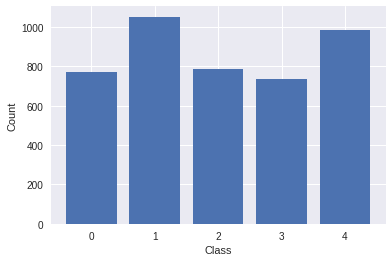

Cases 0 - daisy: 17.789% of all
Cases 1 - dandelion: 24.335% of all
Cases 2 - rose: 18.136% of all
Cases 3 - sunflower: 16.979% of all
Cases 4 - tulip: 22.762% of all


In [12]:
ploting_class(labels)

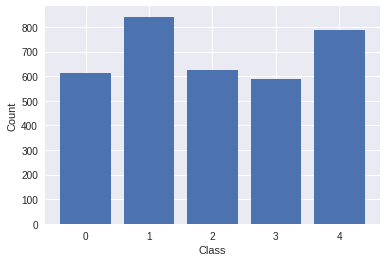

Cases 0 - daisy: 17.785% of all
Cases 1 - dandelion: 24.349% of all
Cases 2 - rose: 18.132% of all
Cases 3 - sunflower: 16.975% of all
Cases 4 - tulip: 22.759% of all


In [13]:
ploting_class(y_train)

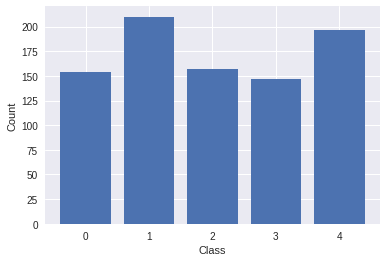

Cases 0 - daisy: 17.803% of all
Cases 1 - dandelion: 24.277% of all
Cases 2 - rose: 18.150% of all
Cases 3 - sunflower: 16.994% of all
Cases 4 - tulip: 22.775% of all


In [14]:
ploting_class(y_validate)

In [15]:
x_train.shape

(3458, 100, 100, 3)

In [16]:
x_validate.shape

(865, 100, 100, 3)

In [0]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_validate = le.fit_transform(y_validate)
y_train = to_categorical(y_train, 5)
y_validate = to_categorical(y_validate, 5)


### Deep Learning
#### 1. Convolutional Neural Network
I create a convolutional neural network with the following layers:
 - Conv2D - 2D Conversion Layer - 32 filters 3x3.
 - MaxPooling2D.
 - BatchNormalization - Structure of the normalization batch.
Normalizes the activation of the previous layer in each batch, i. Applies a transformation that maintains the mean activation close to 0 and the standard deviation of activation close to 1.
 - Conv2D - 2D Conversion Layer - 64 filters 5x5.
 - MaxPooling2D.
 - BatchNormalization.
 - Flatten - Compare input. Does not affect the batch size.
 - Dense.
 - Dropout - Applies dropping the input.
Dropping occurs by accidentally setting a fraction of the input units to 0 at each update during the training time, helping to prevent over-tuning.
 - Dense.

In [0]:
model = Sequential([
  Conv2D(32, (3, 3), activation = 'relu', padding = "Same", input_shape = (100, 100, 3)),
  MaxPooling2D(),
  BatchNormalization(),
  Conv2D(64, (5, 5), activation = 'relu', padding = "Same"),
  MaxPooling2D(),
  BatchNormalization(),
  Flatten(),
  Dense(128, activation='relu'),
  Dropout(0.2),
  Dense(5, activation = 'softmax')
])


Once I've created the model, we can see the parameters in the individual layers.

In [22]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 50, 50, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 64)        51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 25, 25, 64)        256       
_________________________________________________________________
flatten (Flatten)            (None, 40000)             0         
__________


#### 2. Neural Network Training
 - I train the model
 - I show the curves of the accuracy and function of the loss.
 - I check the model how it handles the validation data.

In [0]:
learn_rate = 0.001
model.compile(loss = "categorical_crossentropy", optimizer = Adam(lr = learn_rate), metrics = ["accuracy"])

In [0]:
batch_size = 64
epochs = 20

In [26]:
history = model.fit(x_train, y_train, batch_size = batch_size, epochs = epochs, verbose = 1)

Epoch 1/20
3458/3458 [==============================] - 130s 38ms/step - loss: 1.2518 - acc: 0.4858
Epoch 2/20
3458/3458 [==============================] - 130s 38ms/step - loss: 0.8957 - acc: 0.6484
Epoch 3/20
3458/3458 [==============================] - 129s 37ms/step - loss: 0.6389 - acc: 0.7588
Epoch 4/20
3458/3458 [==============================] - 131s 38ms/step - loss: 0.3790 - acc: 0.8589
Epoch 5/20
3458/3458 [==============================] - 130s 37ms/step - loss: 0.2184 - acc: 0.9320
Epoch 6/20
3458/3458 [==============================] - 129s 37ms/step - loss: 0.1144 - acc: 0.9647
Epoch 7/20
3458/3458 [==============================] - 130s 38ms/step - loss: 0.0725 - acc: 0.9795
Epoch 8/20
3458/3458 [==============================] - 129s 37ms/step - loss: 0.0435 - acc: 0.9893
Epoch 9/20
3458/3458 [==============================] - 130s 38ms/step - loss: 0.0300 - acc: 0.9936
Epoch 10/20
3458/3458 [==============================] - 129s 37ms/step - loss: 0.0381 - acc: 0.9902

In [0]:
def plot_los_accuracy(history):
    accuracy = history.history['acc']
    loss = history.history['loss']
    epochs = range(len(accuracy))
    plt.plot(epochs, accuracy, 'b', label = 'Training Accuracy')
    plt.title('Training accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'b', label = 'Training Loss')
    plt.title('Training loss')
    plt.legend()
    plt.show()

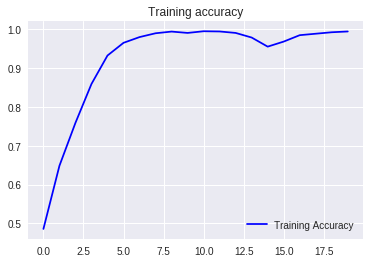

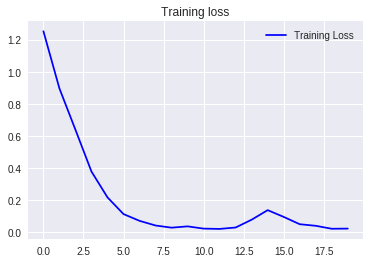

In [28]:
plot_los_accuracy(history)

In [30]:
model.evaluate(x_validate, y_validate)

865/865 [==============================] - 8s 9ms/step


[2.8317897157172935, 0.5410404624277456]


#### 3. Error analysis
Let's predict that human error is 1%. We have ** Variance - 45% **. First, we can optimize hyperparameters. Once we've optimized hyperparamas, it's best to generate more input data.


### Conclusion
There is a small amount of data for the task. We can generate more input data or rewrite one of the neural networks (VGG-19, AlexNet, etc.)